# Model Based Learning

Consider a pendulum with a some unknown mass and unknown dynamics as
your system. Your system takes in as input a torque (clockwise or
counter clockwise). Your goal is to compute a sequence of actions that ensure
the pendulum can stay in an upright position. This is a classic model based
problem and can be broken down to 2 pieces :
1. Learn the model of the system.
2. Using the learned model, use a planner to compute the sequence of states
required to achieve the desired position.
Part a) Implement a system that learns the model of the pendulum.
The state of the pendulum at any time t is given as s(t) = [cos(θ), sin(theta), θ,  ̇θ].
Your output action space is a continuous action space corresponding to the
torque τ applied at the hinge τ ∈ (−2, 2). 



# Part A) Implement a system modelling the pendulum

In [2]:
import gym
import numpy as np
import math
env = gym.make('Pendulum-v0')
env.reset();

### Generate training data

Function to get $\theta, \theta^.$ from the observation obtained from gym

In [3]:
def getThetaThetaDotFromData(observation):
    theta = math.atan2(observation[1], observation[0]);
    return [theta/math.pi, observation[2]]


Convert to a training data object - a list of 3 elements $[\theta, \theta^., \tau]$

In [4]:
def getTrainingSample(observation, action):
    return np.array(getThetaThetaDotFromData(observation) + action.tolist());

Generate 2000000 data points

In [5]:
x = []
y = []
for i_episode in range(2000):
    observation = env.reset()
    for t in range(1000):
        action = env.action_space.sample()
        old_observation = observation
        observation, reward, done, info = env.step(action)
        x.append(getTrainingSample(old_observation, action))
        y.append(np.array(getThetaThetaDotFromData(observation)))
x = np.array(x)
y = np.array(y)

In [6]:
x

array([[ 0.93185157,  0.24024215,  0.19525401],
       [ 0.93867737,  0.42887734,  0.86075747],
       [ 0.94984347,  0.70158691,  0.41105351],
       ..., 
       [ 0.8527639 , -2.66197513,  1.71343434],
       [ 0.81981433, -2.07028235,  1.56677568],
       [ 0.797007  , -1.43302659, -0.0325189 ]])

In [7]:
assert(len(x) == len(y))

### Create a neural network to model the data

In [8]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model, Sequential
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import os
import numpy as np
import tensorflow as tf
import h5py
import math
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


### Architecture:  
3 layers - 3X15, 15x15, 15X2    
ReLu activation functions
Total params: 332  
Trainable params: 332  
Non-trainable params: 0

Input -  3 features describing the state : $\theta, \theta^., \tau$  

Output: 2 outputs, the $\theta, \theta^.$ describing the next state

In [336]:
def get_model():
    # create model
    model = Sequential()
    model.add(Dense(16, input_dim=3, kernel_initializer='normal', activation='relu'))
    model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(Dense(2, kernel_initializer='normal'))
    model.summary()
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [337]:
model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                64        
_________________________________________________________________
dense_5 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 66        
Total params: 674
Trainable params: 674
Non-trainable params: 0
_________________________________________________________________


Training the model on the generated dataset

In [338]:
history = model.fit(x,y,epochs=20, batch_size=50, verbose=1, validation_split=0.1)

Train on 1800000 samples, validate on 200000 samples
Epoch 1/20
1800000/1800000 [==============================] - 86s 48us/step - loss: 0.0590 - val_loss: 0.0156
Epoch 2/20
1800000/1800000 [==============================] - 62s 34us/step - loss: 0.0143 - val_loss: 0.0141
Epoch 3/20
1800000/1800000 [==============================] - 61s 34us/step - loss: 0.0123 - val_loss: 0.0108
Epoch 4/20
1800000/1800000 [==============================] - 60s 34us/step - loss: 0.0102 - val_loss: 0.0071
Epoch 5/20
1800000/1800000 [==============================] - 57s 32us/step - loss: 0.0081 - val_loss: 0.0072
Epoch 6/20
1800000/1800000 [==============================] - 63s 35us/step - loss: 0.0073 - val_loss: 0.0179
Epoch 7/20
1800000/1800000 [==============================] - 61s 34us/step - loss: 0.0068 - val_loss: 0.0059
Epoch 8/20
1800000/1800000 [==============================] - 64s 35us/step - loss: 0.0065 - val_loss: 0.0062
Epoch 9/20
1800000/1800000 [==============================] - 68s 3

## Results

### Training plots

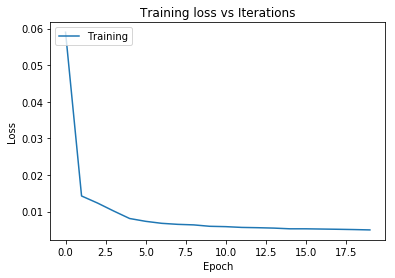

In [339]:
import matplotlib.pyplot as plt
history.history['loss'] = history.history['loss']
plt.plot(history.history['loss'])
plt.title('Training loss vs Iterations')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

Training error : 0.005 (L2 loss)  
Validation error : 0.0042

### Save the model

In [326]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

### Dev testing

In [16]:
observation = env.reset()
action = env.action_space.sample()

x_test = []
x_test.append(np.array(getTrainingSample(observation,action)))
x_test = np.array(x_test)
x_test.shape

(1, 3)

In [17]:
y_hat = model.predict(x_test)

In [18]:
observation, reward, done, info = env.step(action)
(np.array(getThetaThetaDotFromData(observation)))

array([ 0.79159307,  0.13257157])

In [19]:
x_test, y_hat

(array([[ 0.78948313, -0.50177558,  1.15803444]]),
 array([[ 0.79148149,  0.13009129]], dtype=float32))

## Part B

Using the learned model from Part a) and implement a graph based
planner that can compute the most optimal solution. The easiest graph based
planner can be A∗ (reads as A-star). For example, A-star takes in as input the
current state, evaluates reachable states from the current state by computing a
heuristic and then picks the best possible next state according to this heuristic.

In [262]:
torque_options = [x/10 for x in range(-20, 21)]

In [263]:
stateMap = dict() # a map for converting 
stateCount = [0]
decToKeep = 2

Creating a discrete sample space for $\theta, \theta^.$

In [343]:
#Make the search space discrete
def getStateIndex(state):
    v0  = round(state[0],decToKeep)
    v1  = round(state[1],decToKeep)
    roundedState = [v0, v1]

    tupleForState = (roundedState[0],roundedState[1]);
    if(tupleForState in stateMap):
        return stateMap[tupleForState]
    else:
        stateCount[0] =  stateCount[0] + 1
        stateMap[tupleForState] = stateCount[0]
        return stateCount[0]


In [265]:
# Check if a state was already added to a map
def checkExistence(a):
    roundedState = [round(a[0],decToKeep), round(a[1],decToKeep)]
    tupleForState = (roundedState[0],roundedState[1]);
    if(tupleForState in stateMap):
        return True
    else:
        return False

In [344]:
#Check if 2 states equivalent
def checkStateEquals(a,b):
    return getStateIndex(a) == getStateIndex(b)

In [267]:
#Test
state = (1,1.222222)
print(getStateIndex(state))
checkStateEquals((1,1.222),(1.0001,1.222222))
checkExistence((1,1.222222))

1


True


### A Star Algorithm :

Defining a node to run A*
3 values at each node: 
- parent 
- values = $[\theta, \theta.]$
- action

In [328]:
class Node():

    def __init__(self, parent=None, values=None, action=None):
        self.parent = parent
        self.values = values
        self.action = action

        self.g = 0
        self.h = 0
        self.f = 0

    def __eq__(self, other):
        v1 = self.values
        v2 = other.values
        return checkStateEquals((v1[0],v1[1]),(v2[0],v2[1]))
    
    def __str__(self):
        return str(self.values) + " " + str(self.action)
    
    def __repr__(self):
        return str(self.values)

Heuristic: $h = - (\theta^2 + {\theta.}^2 + 0.001a^2_t)$  
This heuristic is essentially our reward, our goal is to remain vertical ($\theta = 0$), with the least velocity ($\theta. = 0$), and the least amount of torque applied.

In [345]:
import math
from queue import PriorityQueue

def getHeuristic(values, action):
    theta = values[0]
    thetaDot = values[1]
    return -(theta**2 + thetaDot**2 + 0.001 * action**2)

A star algo using priority queue

In [327]:
def astarOptimized(start_val,end_val, torque_options, model, start_torque = 0):
    start_node = Node(None, start_val, 0)
    print("Starting at " + str(start_node))
    start_node.g = start_node.h = start_node.f = 0
    end_node = Node(None, end_val, 0)
    came_from = {}
    cost_so_far = {}
    completed = {}
    frontier = PriorityQueue()
    frontier.put((0,start_node))
    startNodeIndex = getStateIndex((start_node.values[0],start_node.values[1]))
    cost_so_far[startNodeIndex] = 0;
    came_from[startNodeIndex] = None
    completed[startNodeIndex] = False
    while not frontier.empty():
        current_node = frontier.get()[1]
        if(current_node == end_node):
            path = []
            current = current_node
            while current is not None:
                path.append(current.action)
                current = current.parent
            return(path[::-1])
            break
        
        current_node_idx = getStateIndex((current_node.values[0],current_node.values[1]))
        
        if(current_node_idx in completed and completed[current_node_idx]):
            continue
        for torque in torque_options:
            next_value = model.predict(np.array([current_node.values + list([torque])]))[0]
            if(~checkExistence((next_value[0], next_value[1]))):
                new_node = Node(current_node, list(next_value), torque)
                heuristic = getHeuristic(next_value, torque)
                nodeIndex = getStateIndex((new_node.values[0],new_node.values[1]))
                cost_so_far[nodeIndex] = cost_so_far[current_node_idx] + heuristic;
                came_from[nodeIndex] = (current_node_idx, torque)
                new_node.f = cost_so_far[nodeIndex]
                frontier.put((cost_so_far[nodeIndex],new_node))
                
        completed[current_node_idx] = True
        
    return []


In [346]:
def getActionSequence(initialObservation):
    init_state = getThetaThetaDotFromData(initialObservation)
    final_state = [0,0]
    stateMap = dict()
    stateCount = [0]
    decToKeep = 1
    return astarOptimized(init_state, final_state, torque_options,model)

### Testing

In [347]:
a = env.reset();
ans = getActionSequence(a)

Starting at [-0.481060575305722, -0.79793782941537561] 0


In [348]:
print(ans)

[0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -1.0, -2.0, -2.0, -2.0, -1.5, -2.0, -2.0, -2.0, -2.0, -2.0, -0.3, 0.3, -0.4, -2.0, -2.0, -1.3, -1.4, -2.0, -1.6, -2.0, -2.0, -0.8, -1.0, -0.6, 0.2, -2.0, 1.8, -2.0, -0.6, -1.9, -1.4, -2.0, -1.8, -0.7, 2.0, 2.0, 1.7, 2.0, 1.9, 1.7, 1.4, 1.2, -1.6, 0.9, -0.9, -1.6, -2.0, -1.8, -1.9, 1.6, 1.6, 1.4, 1.8, 1.6, 1.7, 1.1, 1.5, 1.8, 1.2, -0.3, -1.1, -1.8, -2.0, -1.6, -1.9, 1.8, 1.9, 1.4, 2.0, 1.5, 1.6, 1.1, 1.5, 1.7, 1.4, -0.3, -1.1, -1.7, -2.0, -1.7, -2.0, 1.7, 1.6, 1.2, 1.8, 1.9, 1.5, 1.4, 0.5, 2.0, -2.0, -2.0, 1.6, 1.0, 1.3, 1.2, 0.8, 1.5, 1.8, 1.3, 2.0, 1.9, 1.7, -0.9, 0.3, 1.5, -0.9, -1.6, -2.0, -2.0, -1.3, 1.2, 1.2, 0.7, 1.5, 1.7, 1.8, 1.4, 2.0, 1.8, 0.5, 0.2, 0.6, -0.9, -1.5, -2.0, -2.0, -2.0, 1.7, 1.0, 0.6, 2.0, 1.5, 1.7, 1.4, 1.5, 2.0, 0.8, 0.5, 0.5, -1.0, -1.6, -2.0, -2.0, -1.4, 1.8, 1.7, 1.8, 1.7, 2.0, 1.4, 1.5, 1.5, 1.0, -0.3, -0.5, 1.7, 1.5,